## **Covid Positive X-Ray image data**

Github link: https://github.com/stellamym/Projects-AdvancedML/blob/main/COVID_Hackathon_Model_Submission_Notebook_Yiming_Ma.ipynb

Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

# Discuss the dataset in general

This dataset covers three categories of lung X-Ray images: NORMAL, COVID, and PNEUMONIA. 

*   NORMAL: X-Ray image of normal lung.
*   COVID: X-Ray image of lung with COVID positive.
*   PNEUMONIA: X-Ray image of lung with viral Pneumonia.

The raw dataset covers: 3616 COVID images, 10192 NORMAL images, 1345 VIRAL PNEUMONIA images. 

In this project, we preprocess the dataset and manage into a new dataset with 4032 images. For each of the three category, we cover 1344 images.

The preprocessed dataset covers: 1344 COVID images, 1344 NORMAL images, 1344 VIRAL PNEUMONIA images. 

This project aims to build models to predict the symptom of X-Ray lung image. Starting from 2020, COVID-19 has had a profound impact on the world, affecting nearly every aspect of daily life. The pandemic has caused widespread illness and death, disrupted economies, strained healthcare systems, and forced people to adapt to new ways of working, learning, and socializing.

The model can help identify patients who are likely to have COVID-19 based on their X-ray images. This can help medical professionals to detect the disease early, which is crucial for successful treatment and preventing the spread of the virus. With the help of machine learning algorithms, the model can quickly and accurately analyze large volumes of X-ray images, reducing the workload of medical professionals and speeding up the diagnosis process. Both the patients and the medical professionals can benefit from the model.

Meanwhile, the data collected from the X-ray images can be used for research purposes, helping medical professionals to better understand the disease and develop more effective treatments.

 **Import Data**

In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [2]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1960.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-904.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2435.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-787.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2157.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1257.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3379.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-819.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1690.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1338.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3508.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1990.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-617.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3309.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2410.png', 'COVID-19_Radiography_Dataset/COVID/images/COV

In [5]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

**Data Preprocessing**

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
len(image_filepaths)

4032

In [9]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [10]:
len(fnames[2])

1344

In [11]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


# Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not.

For each category, I present 2 images titled with the category.

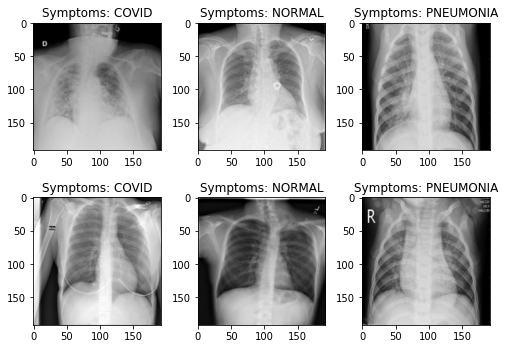

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

fig,ax=plt.subplots(2,3)
fig.set_size_inches(7,5)
ax[0,0].imshow(X[1])
ax[0,0].set_title('Symptoms: '+y_labels[1])
ax[0,1].imshow(X[1345])
ax[0,1].set_title('Symptoms: '+y_labels[1345])
ax[0,2].imshow(X[2689])
ax[0,2].set_title('Symptoms: '+y_labels[2689])
ax[1,0].imshow(X[2])
ax[1,0].set_title('Symptoms: '+y_labels[2])
ax[1,1].imshow(X[1346])
ax[1,1].set_title('Symptoms: '+y_labels[1346])
ax[1,2].imshow(X[2690])
ax[1,2].set_title('Symptoms: '+y_labels[2690])
plt.tight_layout()

# Run at least three prediction models to try to predict x-ray images well.

In [13]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

# **Model 1**

In [14]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 24s 130ms/step - loss: 0.8834 - accuracy: 0.5511 - val_loss: 0.5950 - val_accuracy: 0.7359


In [15]:
model.save("model1.h5", save_format="h5")

In [16]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

This model is #142 on leader board.

# **Model 2**

In [17]:
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [18]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [19]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(112, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model2 = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [20]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model2.fit(X_train, y_train,batch_size=1,
          epochs = 10, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/10
2188/2192 [============================>.] - ETA: 0s - loss: 1.1182 - acc: 0.3396
Epoch 00001: val_acc improved from -inf to 0.34062, saving model to best_model.h5
2192/2192 [==============================] - 27s 12ms/step - loss: 1.1181 - acc: 0.3399 - val_loss: 1.0983 - val_acc: 0.3406 - lr: 0.0100
Epoch 2/10
2189/2192 [============================>.] - ETA: 0s - loss: 1.1003 - acc: 0.3216
Epoch 00002: val_acc did not improve from 0.34062
2192/2192 [==============================] - 24s 11ms/step - loss: 1.1003 - acc: 0.3216 - val_loss: 1.1013 - val_acc: 0.3388 - lr: 0.0100
Epoch 3/10
2191/2192 [============================>.] - ETA: 0s - loss: 1.0997 - acc: 0.3268
Epoch 00003: val_acc did not improve from 0.34062

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 23s 10ms/step - loss: 1.0997 - acc: 0.3266 - val_loss: 1.1078 - val_acc: 0.3406 - lr: 0.0100
Epoch 4/10
2187/2192 [=======================

In [21]:
model2.save("model2.h5", save_format="h5")

This model is #172 on leader board.

# **Model 3**

In [22]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model3 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model3.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 7s 58ms/step - loss: 0.7960 - accuracy: 0.6419 - val_loss: 0.4589 - val_accuracy: 0.7996


In [23]:
model3.save("model3.h5", save_format="h5")

In [24]:
# Reload model and data
import tensorflow as tf
model3 = tf.keras.models.load_model('model3.h5',compile=False)
model3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 95, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 93, 93, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 22, 128)     

This model is #146 on leader board.

# Discuss which models performed better and point out relevant hyper-parameter values for successful models.

From the above experiment, **model 3** works better compares to the others. The relevant hyper-parameter values for this models are:

**Number of filters in the convolutional layers**: The number of filters determines the number of features that the layer can learn. In this model, there are three convolutional layers with 32, 64, and 128 filters, respectively.

**Size of the filters in the convolutional layers:** The size of the filters determines the size of the receptive field of the layer, which affects the amount of spatial information that the layer can capture. In this model, the filters are all of size 3x3.

**Activation function:** The activation function introduces non-linearity into the model and helps the model learn complex relationships between the input and output. In this model, the ReLU activation function is used for the convolutional and dense layers, and the softmax activation function is used for the output layer.

**Pooling size in the max pooling layers:** The pooling size determines the amount of downsampling that occurs in the spatial dimensions of the output. In this model, the pooling size is 2x2.

**Number of units in the dense layers:** The number of units determines the size of the output of the layer. In this model, there is one dense layer with 128 units, followed by an output layer with 3 units.

**Learning rate:** The learning rate determines the step size that is used in the optimization algorithm to update the weights of the model. In this model, the default learning rate is used.


# After learning from team, create one more model

# **Model 4**

In [25]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model4 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model4.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model4.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

69/69 [==============================] - 5s 43ms/step - loss: 2.6483 - accuracy: 0.7016 - val_loss: 0.4579 - val_accuracy: 0.7996


In [26]:
model4.save("model4.h5", save_format="h5")

In [27]:
# Reload model and data
import tensorflow as tf
model4 = tf.keras.models.load_model('model4.h5',compile=False)
model4.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 95, 95, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 288800)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               36966528  
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 36,967,811
Trainable params: 36,967,811
Non-trainable params: 0
__________________________________________

This model is #179 on leader board. So far, this is the best model I have tried.

# Try to use augmented data to rerun at least one model and discuss results

In [28]:
#Augment Image Data Using Keras ImageDataGenerator()
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
# This time we will load images from the original list of filenames, but we will not preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

filenamelist=fnames[0]+fnames[1]+fnames[2]
len(filenamelist)

4032

In [30]:
# Create y data labelsmade up of correctly ordered labels from file folders
from itertools import repeat

covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

4032


In [31]:
# Train test split file names and labels
from sklearn.model_selection import train_test_split

X_train_datagen,X_test_datagen,y_train_datagen,y_test_datagen=train_test_split(filenamelist,y_labels,test_size = 0.32, random_state = 1987)
print(X_train_datagen[0:5])
y_train_datagen[0:5] 

['COVID-19_Radiography_Dataset/Normal/images/Normal-3766.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-380.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-289.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2510.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2267.png']


['NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'COVID']

In [32]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()

,X,y
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
1,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
2,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
3,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID


In [33]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,

        horizontal_flip=True,
        vertical_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical',shuffle=True)

Found 2741 validated image filenames belonging to 3 classes.


In [34]:
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical')

Found 1291 validated image filenames belonging to 3 classes.


In [35]:
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model5 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model5.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


      # fits the model on batches with real-time data augmentation:
      model5.fit(train_generator,
                    steps_per_epoch=len(trainingdata) / 1, epochs=1, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
                    validation_data=validation_generator)

2741/2741 [==============================] - 54s 19ms/step - loss: 0.9826 - accuracy: 0.5089 - val_loss: 0.7823 - val_accuracy: 0.6731


In [39]:
model5.save("model5.h5", save_format="h5")

In [40]:
# Reload model and data
import tensorflow as tf
model5 = tf.keras.models.load_model('model5.h5',compile=False)
model5.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 95, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 93, 93, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 128)     

This model is #182 on leader board. According to the leader board, the accuracy of the model is 61.19%, f1_score of the model is 50.39%, precision of the model is 49.99%. This model is build upon model 3. However, with the augmented data, the result is not as well as model 3.

# Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

I tried 5 models in total. All the five models are TensorFlow Keras Sequential model that defines a convolutional neural network (CNN) architecture for 3-class image classification. The first three models are first created and compared. Among them, the second model uses transfer learning models. The fourth model is created based on the group discussion. The fifth model is created based on augmented data and model 3. 

From the above experiment, model 4 works better compares to the others. The relevant hyper-parameter values for this models are:

**Conv2D**: This layer applies 32 filters of size 3x3 to the input image, with ReLU activation. The padding parameter is not specified, so it defaults to valid padding. This layer has a input_shape parameter of (192, 192, 3), which means the input images have a height and width of 192 pixels and 3 color channels (RGB).

**MaxPooling2D**: This layer performs max pooling with a pool size of 2x2, reducing the height and width of the feature maps by half.

**Flatten**: This layer flattens the output from the previous layer, turning it into a 1D tensor.

**Dense**: This layer has 128 units, with ReLU activation.

**Dense**: This is the output layer with 3 units, representing the 3 classes of the classification problem. It has a softmax activation function which returns the probability of each class.

The model has a total of 307,587 trainable parameters, which includes the weights and biases of all the layers. The hyper-parameter values in this model are relatively simple and not very deep, making it a good starting point for a simple image classification problem. However, it may not be able to achieve high accuracy in more complex classification problems.

